# 11785 - Intro to Deep Learning - Project

In [1]:
# load packages
import os, time, pickle, argparse, utils
import networks as networks
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from edge_promoting import edge_promoting
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import cv2, os
import numpy as np
import random
from tqdm import tqdm

ImportError: cannot import name 'edge_promoting'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Part 1 - Image Preprocessing

Edge promoting has been widely used to generate negative samples for discriminator network, e.g. AnimeGAN, Comix GAN, and CartoonGAN.

In [ ]:
def ImageProcess(root, save, input_size = 128, line_size = 1, 
                 line_length = 12, 
                 height_range = [18*2, 32*2], width_range = [18*2, 38*2],
                 line_num = 6):
    
    file_list = os.listdir(root)
    if not os.path.isdir(save):
        os.makedirs(save)
    kernel_size = 5
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    gauss = cv2.getGaussianKernel(kernel_size, 0)
    gauss = gauss * gauss.transpose(1, 0)
    n = 1
    for f in tqdm(file_list):
        
        rgb_img = cv2.imread(os.path.join(root, f))
        '''
        Edge smoothing
        '''
        gray_img = cv2.imread(os.path.join(root, f), 0)
        rgb_img = cv2.resize(rgb_img, (input_size, input_size))
        pad_img = np.pad(rgb_img, ((2,2), (2,2), (0,0)), mode='reflect')
        gray_img = cv2.resize(gray_img, (input_size, input_size))
        edges = cv2.Canny(gray_img, 100, 200)
        dilation = cv2.dilate(edges, kernel)

        gauss_img = np.copy(rgb_img)
        idx = np.where(dilation != 0)
        for i in range(np.sum(dilation != 0)):
            gauss_img[idx[0][i], idx[1][i], 0] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 0], gauss))
            gauss_img[idx[0][i], idx[1][i], 1] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 1], gauss))
            gauss_img[idx[0][i], idx[1][i], 2] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 2], gauss))

        '''
        detail adding
        '''
        detail_img = rgb_img.copy()
        height_low, height_high = height_range
        width_left, width_right = width_range
        for line in range(line_num):
            start_height = random.randint(0, height_high - height_low) + height_low
            height_direction = random.randint(0, 2*line_length) - line_length
            start_width = random.randint(0, width_right - width_left) + width_left
            width_direction = random.randint(0, 2*line_length) - line_length
            detail_img = cv2.line(detail_img, \
                                (start_height, start_width),\
                                (start_height + height_direction, start_width + width_direction),\
                                (0, 0 ,0), line_size)


        result = np.concatenate((rgb_img, gauss_img, detail_img), 1)
        #result = np.concatenate((rgb_img, detail_img), 1)

        cv2.imwrite(os.path.join(save, str(n) + '.png'), result)
        n += 1

In [2]:
def edge_smoothing(filename):
    kernel_size = 11
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    gauss = cv2.getGaussianKernel(kernel_size, 0)
    gauss = gauss * gauss.transpose(1, 0)
    
    rgb_img = cv2.imread(filename)
    
    gray_img = cv2.imread(filename, 0)
    rgb_img = cv2.resize(rgb_img, (128, 128))
    pad_img = np.pad(rgb_img, ((5,5), (5,5), (0,0)), mode='reflect')
    gray_img = cv2.resize(gray_img, (128, 128))
    edges = cv2.Canny(gray_img, 100, 200)
    dilation = cv2.dilate(edges, kernel)

    gauss_img = np.copy(rgb_img)
    idx = np.where(dilation != 0)
    for i in range(np.sum(dilation != 0)):
        gauss_img[idx[0][i], idx[1][i], 0] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 0], gauss))
        gauss_img[idx[0][i], idx[1][i], 1] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 1], gauss))
        gauss_img[idx[0][i], idx[1][i], 2] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 2], gauss))
    
    plt.imshow(gauss_img)
    plt.title('128x128 image after edge smoothing')
    return gauss_img

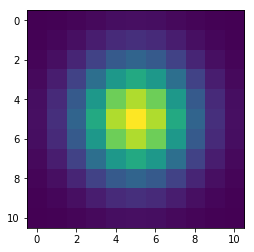

In [96]:
kernel_size = 11
gauss = cv2.getGaussianKernel(kernel_size, 0)
gauss = gauss * gauss.transpose(1, 0)
plt.imshow(gauss)
# gaussian kernel is used to smooth edges in local areas

Text(0.5, 1.0, '128x128 image before edge smoothing')

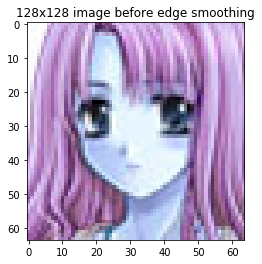

In [97]:
rgb_img = cv2.imread('2.png')
plt.imshow(rgb_img)
plt.title('128x128 image before edge smoothing')

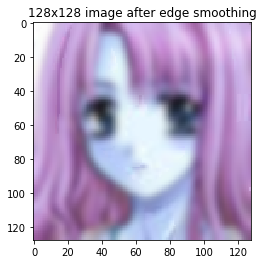

In [98]:
edge_img = edge_smoothing('2.png')

Thinking of generating edge-smoothing imgs as negative sample, we notice the result by GAN could retain too much unnecessary details, like wrinkles. We would like to drop those details, so we did the data augment in a similar way of edge-smoothing by adding random lines on cartoon faces as negative samples.

In [99]:
def detail_adding(filename, input_size = 128, line_size = 1, line_length = 12, height_range = [18*2, 32*2], width_range = [18*2, 38*2],line_num = 10):
    rgb_img = cv2.imread(filename)
    rgb_img = cv2.resize(rgb_img, (128, 128))
    detail_img = rgb_img.copy()
    height_low, height_high = height_range
    width_left, width_right = width_range
    for line in range(line_num):
        start_height = random.randint(0, height_high - height_low) + height_low
        height_direction = random.randint(0, 2*line_length) - line_length
        start_width = random.randint(0, width_right - width_left) + width_left
        width_direction = random.randint(0, 2*line_length) - line_length
        detail_img = cv2.line(detail_img, \
                            (start_height, start_width),\
                            (start_height + height_direction, start_width + width_direction),\
                            (0, 0 ,0), line_size)
    plt.imshow(detail_img)
    plt.title('128x128 image after detail adding')
    
    return detail_img

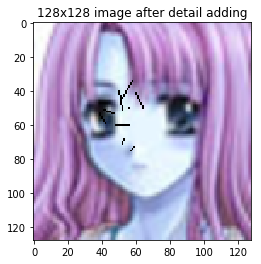

In [100]:
detail_img = detail_adding('2.png')

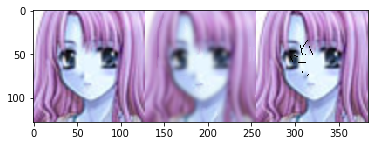

In [101]:
rgb_img = cv2.resize(rgb_img, (128, 128))
plt.imshow(np.concatenate((rgb_img, edge_img, detail_img), 1))

Finally, it concatenate three images. And data loader will read this as target output and negative samples usng slicing.

# Part 2. load source and target data

Source data is real face dataset, from CelebA. Target data is anime face dataset. Both of the datasets are consisted of cropped face images.

In [3]:
src_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

tgt_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [4]:
train_loader_src = utils.data_load('data/src_data',
                                   'train', src_transform,
                                   batch_size = 4,
                                   shuffle=True,
                                   drop_last=True)

# for target data, we only load preprocessed images, the original image is concatenated in it.
train_loader_tgt = utils.data_load('data/tgt_data',
                                   'pair',
                                   tgt_transform,
                                   batch_size = 4,
                                   shuffle=True,
                                   drop_last=True)

# for testing
test_loader_src = utils.data_load('data/src_data',
                                  'test', 
                                   src_transform,
                                   batch_size = 1, 
                                   shuffle=True, 
                                   drop_last=True)

# Part 3. Load models

In [5]:
class InstanceNormalization(nn.Module):
    def __init__(self, dim, eps=1e-9):
        super(InstanceNormalization, self).__init__()
        self.scale = nn.Parameter(torch.FloatTensor(dim))
        self.shift = nn.Parameter(torch.FloatTensor(dim))
        self.eps = eps
        self._reset_parameters()

    def _reset_parameters(self):
        self.scale.data.uniform_()
        self.shift.data.zero_()

    def __call__(self, x):
        n = x.size(2) * x.size(3)
        t = x.view(x.size(0), x.size(1), n)
        mean = torch.mean(t, 2).unsqueeze(2).unsqueeze(3).expand_as(x)
        # Calculate the biased var. torch.var returns unbiased var
        var = torch.var(t, 2).unsqueeze(2).unsqueeze(3).expand_as(x) * ((n - 1) / float(n))
        scale_broadcast = self.scale.unsqueeze(1).unsqueeze(1).unsqueeze(0)
        scale_broadcast = scale_broadcast.expand_as(x)
        shift_broadcast = self.shift.unsqueeze(1).unsqueeze(1).unsqueeze(0)
        shift_broadcast = shift_broadcast.expand_as(x)
        out = (x - mean) / torch.sqrt(var + self.eps)
        out = out * scale_broadcast + shift_broadcast
        return out

In [6]:
class reflection_padded_block(nn.Module):
    def __init__(self, reflection_padding, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        super(reflection_padded_block, self).__init__()
        
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv = nn.Conv2d(in_channels = input_channel,
                              out_channels = output_channel,
                              kernel_size = kernel_size,
                              stride = stride, 
                              padding = padding)
        self.instancenorm = InstanceNormalization(output_channel)
    
    def __call__(self, x):
        x = self.reflection_pad(x)
        x = self.conv(x)
        out = self.instancenorm(x)
        
        return out

In [ ]:
class stacked_conv_block(nn.Module):
    def __init__(self, input_channel, inter_channel, output_channel,
                       kernel_size1 = 3, kernel_size2 = 3,
                       stride1 = 1, stride2 = 2,
                       padding1 = 0, padding2 = 0):
        
        super(stacked_conv_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = input_channel,
                              out_channels = inter_channel,
                              kernel_size = kernel_size1,
                              stride = stride1, 
                              padding = padding1)
        
        self.conv2 = nn.Conv2d(in_channels = inter_channel,
                              out_channels = output_channel,
                              kernel_size = kernel_size2,
                              stride = stride2, 
                              padding = padding2)
        
        self.instancenorm = InstanceNormalization(output_channel)
    
    def __call__(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        out = self.instancenorm(x)
        
        return out

In [ ]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        #
        
        self.activation = nn.LeakyReLU(0.2)
        
        self.ref_pad_1 = reflection_padded_block(reflection_padding = 3,
                                                 input_channel = 3,
                                                 output_channel = 64, 
                                                 kernel_size = 7, 
                                                 stride = 1, 
                                                 padding = 0)
        
        self.stacked_conv_1 = stacked_conv_block(input_channel = 64, inter_channel = 128, output_channel = 128,
                                                   kernel_size1 = 3, kernel_size2 = 3,
                                                   stride1 = 2, stride2 = 1,
                                                   padding1 = 1, padding2 = 1)
        
        self.stacked_conv_2 = stacked_conv_block(input_channel = 128, inter_channel = 256, output_channel = 256,
                                                   kernel_size1 = 3, kernel_size2 = 3,
                                                   stride1 = 2, stride2 = 1,
                                                   padding1 = 1, padding2 = 1)

        ## res block 1
        self.ref_pad_2 = reflection_padded_block(reflection_padding = 1,
                                                 input_channel = 256,
                                                 output_channel = 256, 
                                                 kernel_size = 3, 
                                                 stride = 1, 
                                                 padding = 0)
        # relu
        self.ref_pad_3 = reflection_padded_block(reflection_padding = 1,
                                                 input_channel = 256,
                                                 output_channel = 256, 
                                                 kernel_size = 3, 
                                                 stride = 1, 
                                                 padding = 0)
        # + input

        ## res block 2
        self.ref_pad_4 = reflection_padded_block(reflection_padding = 1,
                                                 input_channel = 256,
                                                 output_channel = 256, 
                                                 kernel_size = 3, 
                                                 stride = 1, 
                                                 padding = 0)
        
        # relu
        self.ref_pad_5 = reflection_padded_block(reflection_padding = 1,
                                                 input_channel = 256,
                                                 output_channel = 256, 
                                                 kernel_size = 3, 
                                                 stride = 1, 
                                                 padding = 0)
            
        # + input

        ## res block 3
        self.ref_pad_6 = reflection_padded_block(reflection_padding = 1,
                                                 input_channel = 256,
                                                 output_channel = 256, 
                                                 kernel_size = 3, 
                                                 stride = 1, 
                                                 padding = 0)
        # relu
        self.ref_pad_7 = reflection_padded_block(reflection_padding = 1,
                                                 input_channel = 256,
                                                 output_channel = 256, 
                                                 kernel_size = 3, 
                                                 stride = 1, 
                                                 padding = 0)
        # + input

        ## res block 4
        self.ref_pad_8 = reflection_padded_block(reflection_padding = 1,
                                                 input_channel = 256,
                                                 output_channel = 256, 
                                                 kernel_size = 3, 
                                                 stride = 1, 
                                                 padding = 0)
        # relu
        self.ref_pad_9 = reflection_padded_block(reflection_padding = 1,
                                                 input_channel = 256,
                                                 output_channel = 256, 
                                                 kernel_size = 3, 
                                                 stride = 1, 
                                                 padding = 0)
        # + input

        ## res block 5
        self.ref_pad_10 = reflection_padded_block(reflection_padding = 1,
                                                 input_channel = 256,
                                                 output_channel = 256, 
                                                 kernel_size = 3, 
                                                 stride = 1, 
                                                 padding = 0)
        # relu
        self.ref_pad_11 = reflection_padded_block(reflection_padding = 1,
                                                 input_channel = 256,
                                                 output_channel = 256, 
                                                 kernel_size = 3, 
                                                 stride = 1, 
                                                 padding = 0)
        # + input

        ## res block 6
        self.ref_pad_12 = reflection_padded_block(reflection_padding = 1,
                                                 input_channel = 256,
                                                 output_channel = 256, 
                                                 kernel_size = 3, 
                                                 stride = 1, 
                                                 padding = 0)
        # relu
        self.ref_pad_13 = reflection_padded_block(reflection_padding = 1,
                                                 input_channel = 256,
                                                 output_channel = 256, 
                                                 kernel_size = 3, 
                                                 stride = 1, 
                                                 padding = 0)
        # + input

        ## res block 7
        self.ref_pad_14 = reflection_padded_block(reflection_padding = 1,
                                                 input_channel = 256,
                                                 output_channel = 256, 
                                                 kernel_size = 3, 
                                                 stride = 1, 
                                                 padding = 0)
        # relu
        self.ref_pad_15 = reflection_padded_block(reflection_padding = 1,
                                                 input_channel = 256,
                                                 output_channel = 256, 
                                                 kernel_size = 3, 
                                                 stride = 1, 
                                                 padding = 0)
        # + input

        ## res block 8
        self.ref_pad_16 = reflection_padded_block(reflection_padding = 1,
                                                 input_channel = 256,
                                                 output_channel = 256, 
                                                 kernel_size = 3, 
                                                 stride = 1, 
                                                 padding = 0)
        # relu
        self.refpad11_2 = nn.ReflectionPad2d(1)
        self.conv11_2 = nn.Conv2d(256, 256, 3)
        self.in11_2 = InstanceNormalization(256)
        # + input

        ##------------------------------------##
        self.deconv01_1 = nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)
        self.deconv01_2 = nn.Conv2d(128, 128, 3, 1, 1)
        self.in12_1 = InstanceNormalization(128)
        # relu
        self.deconv02_1 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.deconv02_2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.in13_1 = InstanceNormalization(64)
        # relu
        self.refpad12_1 = nn.ReflectionPad2d(3)
        self.deconv03_1 = nn.Conv2d(64, 3, 7)
        # tanh

    def forward(self, x):
        
        x = self.activation(self.ref_pad_1(x))
        x = self.activation(self.stacked_conv_1)
        copy = self.activation(self.stacked_conv_2(x))
        
        
        
        
        
        
        y = F.relu(self.in01_1(self.conv01_1(self.refpad01_1(x))))
        y = F.relu(self.in02_1(self.conv02_2(self.conv02_1(y))))
        t04 = F.relu(self.in03_1(self.conv03_2(self.conv03_1(y))))

        ##
        y = F.relu(self.in04_1(self.conv04_1(self.refpad04_1(t04))))
        t05 = self.in04_2(self.conv04_2(self.refpad04_2(y))) + t04

        y = F.relu(self.in05_1(self.conv05_1(self.refpad05_1(t05))))
        t06 = self.in05_2(self.conv05_2(self.refpad05_2(y))) + t05

        y = F.relu(self.in06_1(self.conv06_1(self.refpad06_1(t06))))
        t07 = self.in06_2(self.conv06_2(self.refpad06_2(y))) + t06

        y = F.relu(self.in07_1(self.conv07_1(self.refpad07_1(t07))))
        t08 = self.in07_2(self.conv07_2(self.refpad07_2(y))) + t07

        y = F.relu(self.in08_1(self.conv08_1(self.refpad08_1(t08))))
        t09 = self.in08_2(self.conv08_2(self.refpad08_2(y))) + t08

        y = F.relu(self.in09_1(self.conv09_1(self.refpad09_1(t09))))
        t10 = self.in09_2(self.conv09_2(self.refpad09_2(y))) + t09

        y = F.relu(self.in10_1(self.conv10_1(self.refpad10_1(t10))))
        t11 = self.in10_2(self.conv10_2(self.refpad10_2(y))) + t10

        y = F.relu(self.in11_1(self.conv11_1(self.refpad11_1(t11))))
        y = self.in11_2(self.conv11_2(self.refpad11_2(y))) + t11
        ##

        y = F.relu(self.in12_1(self.deconv01_2(self.deconv01_1(y))))
        y = F.relu(self.in13_1(self.deconv02_2(self.deconv02_1(y))))
        y = F.tanh(self.deconv03_1(self.refpad12_1(y)))

        return y


In [67]:
def load_models(G_path = None, D_path = None):
    G = networks.generator()
    D = networks.discriminator(3, 3, 64) # input_channel, output_channel, and hidden channel
    if G_path != None:
        G.load_state_dict(torch.load(G_path))
    if D_path != None:
        D.load_state_dict(torch.load(D_path))
        
    return G.to(device), D.to(device)

In [68]:
def load_vgg(vgg_path = None):
    if vgg_path != None:
        vgg = networks.VGG19(init_weights = vgg_path, feature_mode = True)
    return vgg.to(device)

In [69]:
G, D = load_models()
VGG = load_vgg('vgg/vgg19.pth')

# Part 4. Pre-train

In this step, we use L1 loss and pretrained VGG model to pretrian generator, so that it is able to reconstruct the original image.

In [102]:
if not os.path.isdir('results/Reconstruction'):
    os.makedirs('results/Reconstruction')

In [ ]:
def pre_train()

In [ ]:
if not os.path.isdir('results/Transfer'):
    os.makedirs('results/Transfer')
